## data preparation

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

2023-11-18 20:16:04.228034: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 20:16:04.250736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 20:16:04.250756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 20:16:04.250774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 20:16:04.255405: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-18 20:16:05.311203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:16:05.314145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:16:05.314223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
POINTS_NUM = 6

import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
phi = np.load('/host/dissertation/proccessed_data/phi.npy')

In [3]:
import sys
ABS_ROOT_DIR_PATH = '/host/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)
from common.model import add_custom_objects_to_keras
add_custom_objects_to_keras()

## manual testing

In [4]:
import cvnn.layers as complex_layers

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_angle'))
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='angle_error')
model.summary()

2023-11-18 20:16:05.679929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:16:05.680093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:16:05.680152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               1792      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 258       
 nse)                                                            
                                                                 
Total params: 35074 (137.01 KB)
Trainable params: 35074 (137.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
from common.model import FreeMemory
history = model.fit(points, phi, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(25)])

2023-11-18 20:16:08.258606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7c1c9db780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 20:16:08.258620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-18 20:16:08.350407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-18 20:16:08.384967: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch 0 ended, info: {'loss': 0.14909139275550842, 'val_loss': 0.03811810910701752}
epoch 25 ended, info: {'loss': 0.012931647710502148, 'val_loss': 0.010270146653056145}
epoch 50 ended, info: {'loss': 0.011370712891221046, 'val_loss': 0.013409032486379147}
epoch 75 ended, info: {'loss': 0.009950320236384869, 'val_loss': 0.006912091746926308}
epoch 100 ended, info: {'loss': 0.009559600614011288, 'val_loss': 0.007058020681142807}
epoch 125 ended, info: {'loss': 0.008941175416111946, 'val_loss': 0.008766941726207733}
epoch 150 ended, info: {'loss': 0.008818177506327629, 'val_loss': 0.005962586961686611}
epoch 175 ended, info: {'loss': 0.008445351384580135, 'val_loss': 0.00635287631303072}
epoch 200 ended, info: {'loss': 0.008017582818865776, 'val_loss': 0.018153173848986626}
epoch 225 ended, info: {'loss': 0.008002962917089462, 'val_loss': 0.005277201998978853}


1st percentile of train loss:       7.6226e-03
1st percentile of validation loss:  5.1917e-03


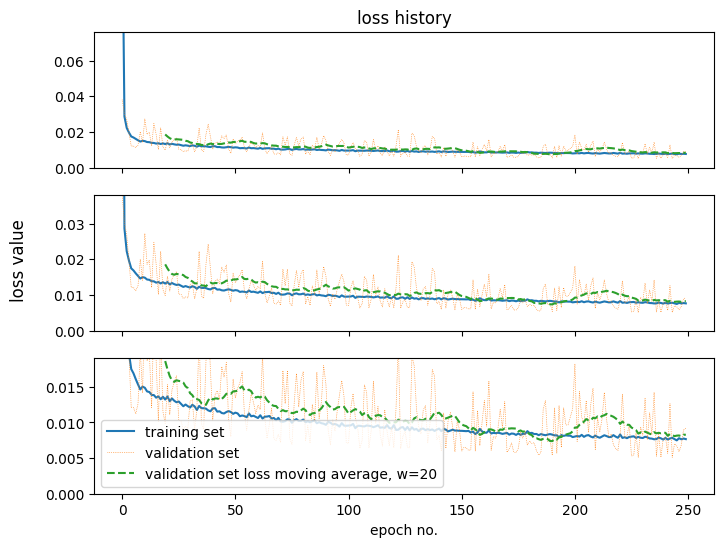

In [6]:
from common.plot import plot_metric_history_zoomed
plot_metric_history_zoomed(history, moving_average_window=(20,))

 83/256 [========>.....................] - ETA: 0s

256/256 [==============================] - 0s 596us/step


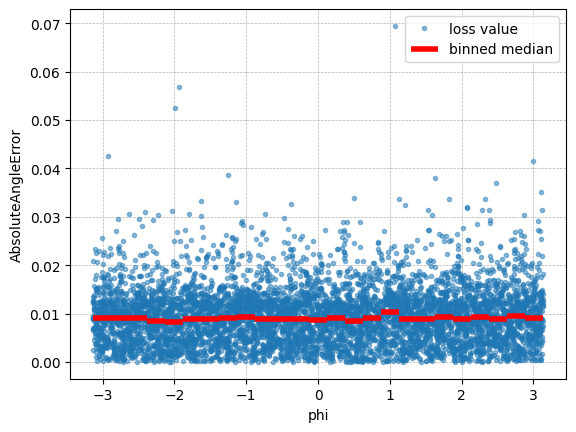

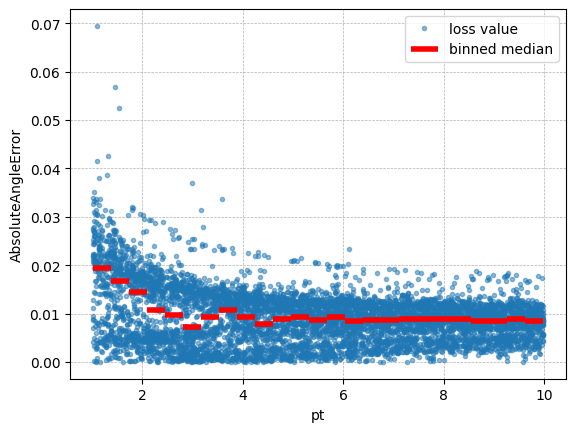

In [10]:
from common.utils import validation_set, train_set
from common.plot import plot_loss_by_parameter

import tensorflow.math as tf_math
metric = lambda y_true, y_pred: tf_math.abs(tf_math.atan2(tf_math.sin(y_true - y_pred), tf_math.cos(y_true - y_pred)))
result = metric(phi, np.asarray(model.predict(points)).flatten())

plot_loss_by_parameter(train_set(result), train_set(phi), 'AbsoluteAngleError', 'phi', statistic='median')
pt = np.load('/host/dissertation/proccessed_data/pt.npy')
plot_loss_by_parameter(train_set(result), train_set(pt), 'AbsoluteAngleError', 'pt', statistic='median')#, ylim=(0,0.03)

## space search

In [ ]:
from common.search import ConfigsTester
from common.model import convert_to_real_with_angle

configs_tester = ConfigsTester(spacepoints_number_space = [3,8,],
                               hiddenlayers_number_space = [2,3,],
                               hiddenlayers_neurons_number_space = [192,96,],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh','cart_relu',],
                               outputlayer_activation_func_space = ['convert_to_real_with_angle'],
                               save_path = '/host/dissertation/trained_models/phi/')

In [ ]:
from common.model import FreeMemory

configs_tester.test_configs(y_data=phi,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='angle_error', 
                            epochs=250, 
                            scenario='q outputlayer_activation_func_space',
                            callbacks=[FreeMemory()])

START (3, 2, 192, 'pol_sigmoid', 'convert_to_real_with_angle')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (3, 2, 192, 'pol_sigmoid', 'convert_to_real_with_angle')
START (3, 2, 192, 'pol_tanh', 'convert_to_real_with_angle')
      model compiled
      training...


KeyboardInterrupt: 